## Training Script

In [1]:
import torch

# Check if CUDA is available and if PyTorch is using GPU
if torch.cuda.is_available():
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Using CPU.")
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(torch.cuda.memory_summary(device=None, abbreviated=False))
    

CUDA is available. Using GPU: NVIDIA GeForce RTX 3080
cuda:0
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|  

### Dataloader

In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

class ClutteredMNISTDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Custom dataset for Cluttered MNIST.
        :param root_dir: Root directory of the dataset (e.g., "dataset/cluttered_mnist")
        :param transform: Optional torchvision transforms to apply to the images
        """
        self.root_dir = root_dir
        self.transform = transform

        # Gather all image paths and their labels
        self.data = []
        for label in range(10):  # Assuming labels are 0-9
            label_dir = os.path.join(root_dir, str(label))
            if os.path.isdir(label_dir):
                for file_name in os.listdir(label_dir):
                    if file_name.endswith(('.png', '.jpg', '.jpeg')):
                        file_path = os.path.join(label_dir, file_name)
                        self.data.append((file_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieve an image and its label at the specified index.
        :param idx: Index of the data point
        :return: Tuple (image, label)
        """
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert('L')  # Convert to grayscale

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms for the dataset
transform = transforms.Compose([
    transforms.Resize((100, 100)),  # Resize images to 100x100
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    # transforms.Normalize((0.1307,), (0.3081,))  # Normalize using MNIST mean and std
])

# Create dataset
dataset_dir = "dataset/cluttered_mnist"
cluttered_mnist_dataset = ClutteredMNISTDataset(root_dir=dataset_dir, transform=transform)

# Split dataset into train and test (80% train, 20% test)
train_size = int(0.9 * len(cluttered_mnist_dataset))
test_size = len(cluttered_mnist_dataset) - train_size
train_dataset, test_dataset = random_split(cluttered_mnist_dataset, [train_size, test_size])

# DataLoader for batching and shuffling
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Example: Iterate through the DataLoader
for images, labels in train_loader:
    print("Training batch of images shape:", images.shape)  # (batch_size, 1, 100, 100)
    print("Training batch of labels shape:", labels.shape)  # (batch_size,)
    break

for images, labels in test_loader:
    print("Test batch of images shape:", images.shape)  # (batch_size, 1, 100, 100)
    print("Test batch of labels shape:", labels.shape)  # (batch_size,)
    break

print(f"train_size: {train_size}, test_size: {test_size}")

Training batch of images shape: torch.Size([64, 1, 100, 100])
Training batch of labels shape: torch.Size([64])
Test batch of images shape: torch.Size([64, 1, 100, 100])
Test batch of labels shape: torch.Size([64])
train_size: 54000, test_size: 6000


### Define the Model

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from glimpse import GlimpseModel

"""print('the code god was here')"""
# Define the RNN model
class MNISTRNN(nn.Module):
    def __init__(self, image_size, hidden_size, num_layers, num_classes, num_kernels, device="cuda:0"):
        super(MNISTRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.image_size = image_size
        self.num_kernels = num_kernels

        # RNN to process the crops
        self.rnn = nn.RNN(num_kernels, hidden_size, num_layers, batch_first=True)
        self.fc_class = nn.Linear(hidden_size, num_classes)  # Class prediction
        self.fc_action = nn.Linear(hidden_size, 2)  # Next crop center prediction
        
        self.eyes = GlimpseModel((image_size, image_size), num_kernels, device)
        

    def forward(self, images, actions, h0, print_tensor=False):
        """
        Forward pass with dynamic cropping and RNN processing.
        :param image: Full input image (batch_size, 1, 28, 28)
        :param center: Initial crop centers (batch_size, 2)
        :param h0: Initial hidden state (num_layers, batch_size, hidden_size)
        :return: Class prediction, next center, hidden state
        """
        batch_size = len(images)
        
        sz = torch.ones((batch_size, 1), device=device)

        
         # TODO: This is the thing that we need to control.
        input = images.squeeze(1)
        output_tensor = self.eyes(input, actions, sz) # (B, 144)
        
        sensor_readings = output_tensor

        # # Process with RNN
        # crops = crops.unsqueeze(1)  # Add sequence dimension (batch_size, seq_len=1, crop_size^2)
        rnn_input = output_tensor.view(batch_size, 1, self.num_kernels)
        
        
        out, hn = self.rnn(rnn_input, h0)
        
        # Predict class and next crop center
        class_pred = self.fc_class(out[:, -1, :])  # Class prediction
        action_pred = torch.tanh(self.fc_action(out[:, -1, :]))  # Action (next crop center)

        return class_pred, action_pred, hn, sensor_readings

### Hyperparameters

In [4]:
# Hyperparameters
image_size = 100
hidden_size = 512
num_layers = 2
num_classes = 10
batch_size = 64
learning_rate = 0.0002
num_epochs = 100
num_steps = 3  # RNN steps per image
num_kernels = 12*12

In [ ]:
# Create model, optimizer, and loss functions
model = MNISTRNN(image_size, hidden_size, num_layers, num_classes, num_kernels, device)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion_class = nn.CrossEntropyLoss()
criterion_action = nn.MSELoss()  # For predicting the next center

## Train That Bad Boy

In [6]:

import matplotlib.pyplot as plt
from datetime import datetime
import logging



create_movie = True

# Create model folder
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

models_path = os.path.join("models", timestamp)
os.makedirs(models_path)
print("Created New Folder:", models_path)

# Initialize Logging
log_file_path = os.path.join(models_path, "training_log.txt")

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(message)s",
    handlers=[
        logging.FileHandler(log_file_path),
        logging.StreamHandler()  # Print to console
    ]
)

if create_movie:
    video_path = os.path.join("video_frames", timestamp)
    print("Created New Folder:", video_path)
    os.makedirs(video_path)
    vid_background_img = torch.zeros((100, 100))
    
    video_frame = 0

# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        batch_size = images.size(0)

        # Initialize the hidden state and center
        h0 = torch.zeros(num_layers, batch_size, hidden_size).to(images.device)
        
        next_actions = torch.zeros((batch_size, 2), device=images.device)

        optimizer.zero_grad()

        loss = 0
        for step in range(num_steps):
            # Print the image out
            
            # next_actions = torch.zeros_like(next_actions, device=next_actions.device) #TODO: remove this line please
            # Forward pass    
            class_pred, action_pred, h0, sensor_readings = model(images, next_actions, h0)
            
            if (i + 1) % 100 == 0:
                sz = torch.ones((1), device=device)
                img = images[0][0]
                sc = next_actions[0] 
                img_name = f"pictures/iter{i+1}_step{step}.png"
                model.eyes.plot_image(img_name, img, sc, sz, sensor_readings[0])
                
            
            # Compute losses
            loss_class = criterion_class(class_pred, labels)
            loss += loss_class
            
            
            next_actions = action_pred
            
            # print(f"step{step}: memory update")
            # print("", torch.cuda.memory_summary(device='cuda:0'))

        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        predicted = torch.argmax(class_pred.data, 1)
        
        accuracy = (predicted == labels).sum()

        if (i + 1) % 100 == 0:
            log_message = (f"Epoch [{epoch + 1}/{num_epochs}], "
               f"Step [{i + 1}/{len(train_loader)}], "
               f"Loss: {loss.item():.4f}, "
               f"Accuracy: {accuracy.item():.4f}")

            logging.info(log_message)
            
            # create movie
            if create_movie:
                frame_file = os.path.join(video_path, f"frame_{video_frame}.png")
                model.eyes.plot_image(frame_file, vid_background_img, torch.zeros((2), device=device), sz, torch.zeros(144))
                video_frame += 1
    
    # Save the model checkpoint
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        # 'loss': 0.25,  # Example loss
    }

    # Save the checkpoint
    checkpoint_path = os.path.join(models_path, f"checkpoint_{epoch}.pth")
    torch.save(checkpoint, checkpoint_path)
    
    

Created New Folder: models/2024-11-26_11-55-16
Created New Folder: video_frames/2024-11-26_11-55-16


2024-11-26 11:55:34,138 - Epoch [1/100], Step [100/844], Loss: 6.8807, Accuracy: 9.0000
2024-11-26 11:55:51,089 - Epoch [1/100], Step [200/844], Loss: 6.9025, Accuracy: 6.0000
2024-11-26 11:56:08,029 - Epoch [1/100], Step [300/844], Loss: 6.7141, Accuracy: 12.0000
2024-11-26 11:56:24,966 - Epoch [1/100], Step [400/844], Loss: 6.8732, Accuracy: 8.0000
2024-11-26 11:56:41,915 - Epoch [1/100], Step [500/844], Loss: 6.7442, Accuracy: 14.0000
2024-11-26 11:56:58,867 - Epoch [1/100], Step [600/844], Loss: 6.6148, Accuracy: 13.0000
2024-11-26 11:57:15,836 - Epoch [1/100], Step [700/844], Loss: 6.5384, Accuracy: 15.0000
2024-11-26 11:57:32,792 - Epoch [1/100], Step [800/844], Loss: 6.5395, Accuracy: 9.0000
2024-11-26 11:57:57,155 - Epoch [2/100], Step [100/844], Loss: 6.6499, Accuracy: 11.0000
2024-11-26 11:58:14,105 - Epoch [2/100], Step [200/844], Loss: 6.3352, Accuracy: 15.0000
2024-11-26 11:58:31,059 - Epoch [2/100], Step [300/844], Loss: 6.5108, Accuracy: 11.0000
2024-11-26 11:58:48,007 -

In [8]:
print()

### Investigate The Model

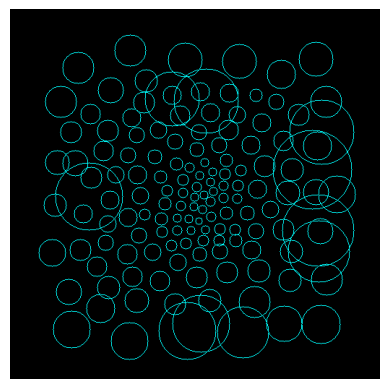

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# print(model.eyes.mu)
# print(model.eyes.sigma)

background_img = torch.zeros((100, 100))
sc = torch.zeros((2), device=device)
sz = torch.ones((1), device=device)

sensor_readings = torch.zeros(144)

# Plot an image
image_name = "out.png"
model.eyes.plot_image(image_name, background_img, sc, sz, sensor_readings)
img = mpimg.imread(image_name)
plt.imshow(img)
plt.axis("off")  # Turn off axis labels
plt.show()

In [9]:
# Evaluate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        batch_size = images.size(0)
        h0 = torch.zeros(num_layers, batch_size, hidden_size).to(images.device)
        next_actions = torch.zeros((batch_size, 2), device=images.device)
        
        for step in range(num_steps):
            class_pred, action_pred, h0, sensor_readings = model(images, next_actions, h0)
            
            next_actions = action_pred

        # print(class_pred.data)
        _, predicted = torch.max(class_pred.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if total > 10000:
            break
        

    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

Accuracy of the model on the test images: 96.66%
